In [23]:
import os 
import glob
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


In [3]:
from matplotlib import font_manager,rc

#폰트 경로
font_path = "C:/Windows/Fonts/gulim.ttc"
 
#폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()
 
#font 설정
rc('font',family=font_name)

# 데이터 로드

In [4]:
BASE_DIR = os.path.dirname(os.path.abspath('.'))+"\\data\\PostCorona\\"
card = pd.read_csv(BASE_DIR + "card.csv")

In [5]:
# 메모리 부족으로 인해 원본의 1% 샘플링 데이터로 선진행
card = card.sample(int(card.shape[0]/100))
card.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37776 entries, 758849 to 3393440
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   receipt_dttm          37776 non-null  int64 
 1   adstrd_code           37776 non-null  int64 
 2   adstrd_nm             37776 non-null  object
 3   mrhst_induty_cl_code  37776 non-null  int64 
 4   mrhst_induty_cl_nm    37776 non-null  object
 5   selng_cascnt          37776 non-null  object
 6   salamt                37776 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.3+ MB


# 전처리
- 잘못된데이터 행 제거
- 시간컬럼 변환

In [6]:
# 잘못된 행 제거
err_values = ["석재", "커텐", "영상물", "복지매장", "축협직영매장"]
for err_value in err_values:
    card = card.drop(   card[card["selng_cascnt"] == err_value].index )

# 순서 정리
card = card[['receipt_dttm',  'adstrd_code', 'adstrd_nm', 'mrhst_induty_cl_code',
       'mrhst_induty_cl_nm', 'selng_cascnt', 'salamt']]

# 날짜컬럼 변환
card['receipt_dttm'] = pd.to_datetime(card['receipt_dttm'], format='%Y%m%d')

# 산업분류코드 컬럼 문자열로 바꿔서 앞두글자 조회가능케 하기
card.mrhst_induty_cl_code = card.mrhst_induty_cl_code.astype('str')

# 매출액, 매출건수 int형으로 변환
card["selng_cascnt"] = card["selng_cascnt"].astype("int64") 
card["salamt"] = card["salamt"].astype("int64") 

card.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37163 entries, 758849 to 3393440
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   receipt_dttm          37163 non-null  datetime64[ns]
 1   adstrd_code           37163 non-null  int64         
 2   adstrd_nm             37163 non-null  object        
 3   mrhst_induty_cl_code  37163 non-null  object        
 4   mrhst_induty_cl_nm    37163 non-null  object        
 5   selng_cascnt          37163 non-null  int64         
 6   salamt                37163 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.3+ MB


In [7]:
# 결측치 확인
# import seaborn as sns
# sns.heatmap(card.isnull(), cbar=False )

## 소분류 업소종명 모으기
- 중분류 산업코드별 소분류 업소종명 모으기


In [8]:
# 산업코드와 업종명으로 군집화
agg = card.groupby(["mrhst_induty_cl_code", "mrhst_induty_cl_nm"]).sum().reset_index()

# 술집 중분류 코드 획득
# 일반음식점 또는 "주"자로 시작하는 주점 따위의 코드획득
target_kind = "주"
agg[agg.mrhst_induty_cl_nm.str.slice(stop=1)==target_kind]

,mrhst_induty_cl_code,mrhst_induty_cl_nm,adstrd_code,selng_cascnt,salamt
44,3201,주방 용구,163200554900,1039,67669900
45,3202,주방용식기,87719191400,487,25737385
48,3301,주 유 소,437712612100,66803,3358310223
140,6140,주 차 장,444559973800,29308,234415907
178,8013,주점,726404761900,33385,1508088090
185,8303,주류판매점,82891402400,549,74920038


In [9]:
card[(card.mrhst_induty_cl_code.str.slice(stop=2)=="80")].mrhst_induty_cl_nm.unique()

array(['서양음식', '일반한식', '스넥', '주점', '중국음식', '일식회집', '위탁급식업', '칵테일바',
       '갈비전문점', '한정식'], dtype=object)

In [10]:
agg[(agg.mrhst_induty_cl_nm=="칵테일바")|
    (agg.mrhst_induty_cl_nm=="주점")]

,mrhst_induty_cl_code,mrhst_induty_cl_nm,adstrd_code,selng_cascnt,salamt
177,8010,칵테일바,296964094300,2090,107338340
178,8013,주점,726404761900,33385,1508088090


## bin ( bucket ) 의 뜻
### bin : 계급 = 변수의 구간 = 가로축 interval
- divide the entire range of values into a series of intervals
<br>

- 히스토그램(histogram)은 표로 되어 있는 도수 분포를 정보 그림으로 나타낸 것이다. 더 간단하게 말하면, 도수분포표를 그래프로 나타낸 것이다. 

- 보통 히스토그램에서는 가로축이 계급, 세로축이 도수를 뜻하는데, 때때로 반대로 그리기도 한다. 
    - 계급은 보통 변수의 구간이고, 서로 겹치지 않는다. 
    - 그림에서 계급(막대기)끼리는 서로 붙어 있어야 한다. 
    - 히스토그램은 일반 막대그래프와는 다르다. 
    - 막대그래프는 계급 즉 가로를 생각하지 않고 세로의 높이로만 나타내지만 히스토그램은 가로와 세로를 함께 생각해야 한다.
    
### Choosing the number of bins
- By default, the number of bins is chosen so that this number is comparable to the typical number of samples in a bin. 
- This number can be customized, as well as the range of values.


## plotly express 기본 히스토그램

In [11]:
data           = card
target_kindcol = "mrhst_induty_cl_nm"
target_kinds    = ["칵테일바", "주점"]
target_kind = target_kinds[1]
target_bincol  = "salamt"
target_gbcol   = ["receipt_dttm","adstrd_nm"]

data = data[data[target_kindcol]==target_kind
           ].groupby(target_gbcol).sum().reset_index()

fig = px.histogram(data, 
                   x=target_bincol, nbins=20)
fig.show()

## go.Histogram 기본

In [13]:
fig = go.Figure(data=[go.Histogram(
    x=data[target_bincol]
    
)])
fig.show()

## subplot위한 변수명생성
- 하나의 업종별을 연습해본 결과, 더 많은 업종을 확인하고 싶어 졌다
    1. 여러 업종을 target_kinds 라는 리스트에 담아서 
    1. 반복문으로 trace0 ~ trace2 등에 담은 후
    1. 그래프에 그려보자

In [14]:
data           = card
target_kindcol = "mrhst_induty_cl_nm"
target_kinds   = ["칵테일바", "주점"]
target_kind    = target_kinds[0]
target_bincol  = "salamt"
target_gbcol   = ["receipt_dttm","adstrd_nm"]
traces = []
for i in range(len(target_kinds)):
    trace = "trace0"
    trace = trace + str(i)
    traces.append(trace)
    traces[i] = data[data[target_kindcol]==target_kinds[i]
           ].groupby(target_gbcol).sum().reset_index()
traces[1].head(2)

,receipt_dttm,adstrd_nm,adstrd_code,selng_cascnt,salamt
0,2020-01-04,원효로1동,1117056000,67,2475150
1,2020-01-05,구의1동,1121585000,99,3750000


In [15]:
fig = make_subplots(rows=2, cols=1)

for i in range(len(target_kinds)):
    traces[i] = data[data[target_kindcol]==target_kinds[i]
           ].groupby(target_gbcol).sum().reset_index()
    traces[i] = go.Histogram(x=traces[i][target_bincol])
    fig.append_trace(traces[i], i+1, 1)
fig.show()

### Combined statistical representations with px.histogram

In [16]:
data           = card
target_kindcol = "mrhst_induty_cl_nm"
target_kinds   = ["칵테일바", "주점"]
target_bincol  = "salamt"
target_gbcol   = ["receipt_dttm","adstrd_nm"]

# (서브플롯을 그리기 위해)
# 원하는 품목리스트(tarket_kinds)의 길이만큼의 리스트를 만들고
# 해당품목의 데이터프레임을 각각 담은 변수 traces 
traces = []
traces_all = pd.DataFrame()
    
for i in range(len(target_kinds)):
    trace = "trace0"
    trace = trace + str(i)
    traces.append(trace)
    traces[i] = data[data[target_kindcol]==target_kinds[i]].groupby(target_gbcol).sum().reset_index()
    traces[i][target_kindcol] = target_kinds[i]
# traces의 각 데이터프레임을 concat 하는것
# (그래프에 따라 종류파라미터 color 또는 hue를 이렇게 원하는 경우도 있음)
    if traces[i].empty == False:
        traces_all = pd.concat([traces_all, traces[i]]) # 아래내용과 동일

# traces_all = pd.DataFrame()
# for target_kind in target_kinds:
#     trace = data[data[target_kindcol] == target_kind].groupby(target_gbcol).sum().reset_index()
#     trace[i][target_kindcol] = target_kinds[i]
#     if trace.empty == False:
#         traces_all = pd.concat([traces_all, trace])

In [17]:
fig = px.histogram(traces_all, 
                   x=target_bincol, 
                   y="selng_cascnt", 
                   color=target_kindcol,
                   marginal="box", # or violin, rug
#                    hover_data=traces_all.columns
                  )
fig.show()

### Plot Hist and Rug with Different Bin Sizes


In [18]:
data           = card
target_kindcol = "mrhst_induty_cl_nm"
target_kinds   = ["칵테일바", "주점"]
target_bincol  = "salamt"
target_gbcol   = ["receipt_dttm","adstrd_nm"]

traces = []
traces_all = pd.DataFrame()
    
for i in range(len(target_kinds)):
    trace = "trace0"
    trace = trace + str(i)
    traces.append(trace)
    traces[i] = data[data[target_kindcol]==target_kinds[i]].groupby(target_gbcol).sum().reset_index()
    traces[i][target_kindcol] = target_kinds[i]
    if traces[i].empty == False:
        traces_all = pd.concat([traces_all, traces[i]])

In [19]:
# colors = ['#393E46', #'#2BCDC1', 
#           '#F66095']
# hist_data = []
# for i in range(len(target_kinds)):
#     hist_data.append(traces[i][target_bincol])

# group_labels = target_kinds

# fig = ff.create_distplot(hist_data, group_labels, colors=colors,
# #                          bin_size=[0.3, 0.1], 
# #                          show_curve=False
#                         )

# # Add title
# fig.update(layout_title_text='Hist and Rug Plot')
# fig.show()

### pandas로 그리기

In [34]:
data           = card
target_kindcol = "mrhst_induty_cl_nm"
target_kinds   = ["칵테일바", "주점"]
target_bincol  = "salamt"
target_gbcol   = ["receipt_dttm","adstrd_nm"]

traces = []
traces_all = pd.DataFrame()
    
for i in range(len(target_kinds)):
    trace = "trace0"
    trace = trace + str(i)
    traces.append(trace)
    traces[i] = data[data[target_kindcol]==target_kinds[i]].groupby(target_gbcol).sum().reset_index()
    traces[i][target_kindcol] = target_kinds[i]
    if traces[i].empty == False:
        traces_all = pd.concat([traces_all, traces[i]])
        
# df = pd.DataFrame({'2012': np.random.randn(200),
#                    '2013': np.random.randn(200)+1})
fig = ff.create_distplot(
#     [df[c] for c in df.columns], 
    [ traces_all[traces_all[target_kindcol]==target_kind]
     for target_kind in target_kinds ],
                         target_kinds, 
#                          bin_size=.25
                        )
fig.show()

PlotlyError: Oops, this function was written to handle multiple datasets, if you want to plot just one, make sure your hist_data variable is still a list of lists, i.e. x = [1, 2, 3] -> x = [[1, 2, 3]]

In [42]:
len([ traces_all[traces_all[target_kindcol]==target_kind] for target_kind in target_kinds ])

2

In [44]:
[ traces_all[traces_all[target_kindcol]==target_kind].target_bincol 
 for target_kind in target_kinds ]

AttributeError: 'DataFrame' object has no attribute 'target_bincol'

In [39]:
        
df = pd.DataFrame({'2012': np.random.randn(200),
                   '2013': np.random.randn(200)+1})
len([df[c] for c in df.columns]),[df[c] for c in df.columns]

(2,
 [0      0.588332
  1     -1.146459
  2      0.941475
  3     -1.130796
  4      0.228432
           ...   
  195    0.134003
  196   -0.682767
  197   -0.806329
  198   -0.278928
  199   -1.196273
  Name: 2012, Length: 200, dtype: float64,
  0     -0.405527
  1      1.057872
  2     -0.483747
  3      0.145995
  4      0.901064
           ...   
  195    3.389363
  196   -0.221265
  197    0.134786
  198    0.319745
  199    1.126747
  Name: 2013, Length: 200, dtype: float64])

# Overlaid Histogram

In [21]:
x0 = np.random.randn(500)
# Add 1 to shift the mean of the Gaussian distribution
x1 = np.random.randn(500) + 1

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0))
fig.add_trace(go.Histogram(x=x1))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

## 건수가 너무 큰 품목 제외하고 그리기

List of 'mrhst_induty_cl_nm' sorted by its count Index(['비료/농약/사료/종자', '농기계', '기타농업관련'], dtype='object', name='mrhst_induty_cl_nm')


Text(0.5, 1.0, "국가표준분류코드 : 96에 해당하는 세분류 구매금액, \n 포함항목 ['농기계' '비료/농약/사료/종자' '기타농업관련'], \n 제외항목 : []")

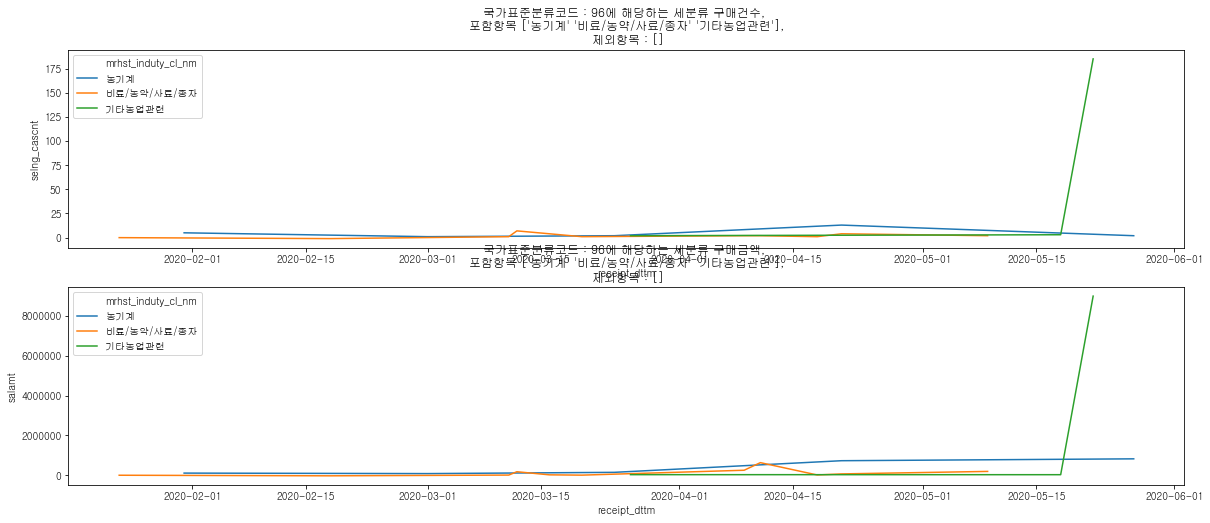

In [24]:
CODES  = ['84', '11', '43', '41', '32', '60', '62', '95', '96']
CODE   = '96'
X      = card[card["mrhst_induty_cl_code"].str.slice(stop=2) == "{}".format(CODE)]
Y      = ['selng_cascnt', "salamt"]

# 건수 및 금액으로 정렬한것중 상위 몇개를 제거한다
remove_ctgrys = X.groupby('mrhst_induty_cl_nm').count().sort_values(Y, ascending=False).index
print("List of 'mrhst_induty_cl_nm' sorted by its count", remove_ctgrys)

if len(remove_ctgrys) >=5:
  remove_ctgrys = remove_ctgrys[:2]
else:
  remove_ctgrys = []

for remove_ctgry in remove_ctgrys:
    print(len(X[X["mrhst_induty_cl_nm"]== remove_ctgry]))
    if len(X[X["mrhst_induty_cl_nm"]== remove_ctgry]) > 0:
        print( "col_name = {}, the number of ctgry removed : {}".format(str(remove_ctgry),
                len( X[X["mrhst_induty_cl_nm"]==remove_ctgry].index)) )
        X = X.drop(index = X[X["mrhst_induty_cl_nm"]==remove_ctgry].index)

    elif len(X[X["mrhst_induty_cl_nm"]== remove_ctgry]) == 0:
        print("No ctgrys :", str(remove_ctgry) )
        
# 제거된것으로 그래프를 그려본다
fig,axes = plt.subplots(2,1,figsize=(20,8))
sns.lineplot( x = pd.to_datetime(X['receipt_dttm'], format='%Y%m%d'), 
              y = Y[0], # 개수
              data = X, ax=axes[0], hue = "mrhst_induty_cl_nm", estimator = np.sum, ci = None 
).set_title("국가표준분류코드 : {}에 해당하는 세분류 구매건수, \n 포함항목 {}, \n 제외항목 : {}"
            .format(CODE, X["mrhst_induty_cl_nm"].unique(), remove_ctgrys[:len(remove_ctgrys)]) )

sns.lineplot( x = pd.to_datetime(X['receipt_dttm'], format='%Y%m%d' ), 
              y = Y[1], # 금액 
              data = X, ax=axes[1], hue = "mrhst_induty_cl_nm", estimator = np.sum, ci = None 
).set_title("국가표준분류코드 : {}에 해당하는 세분류 구매금액, \n 포함항목 {}, \n 제외항목 : {}"
            .format(CODE, X["mrhst_induty_cl_nm"].unique(), remove_ctgrys[:len(remove_ctgrys)]) )